In [261]:
import numpy as np
import nest
import matplotlib.pyplot as plt
from matplotlib import rcParams 
from matplotlib.widgets import Button, Slider


May 08 14:19:29 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.01 ms.

May 08 14:19:29 NodeManager::prepare_nodes [Info]: 
    Preparing 72 nodes for simulation.

May 08 14:19:29 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 72
    Simulation time (ms): 10
    Number of OpenMP threads: 16
    Number of MPI processes: 1

May 08 14:19:29 SimulationManager::run [Info]: 
    Simulation finished.


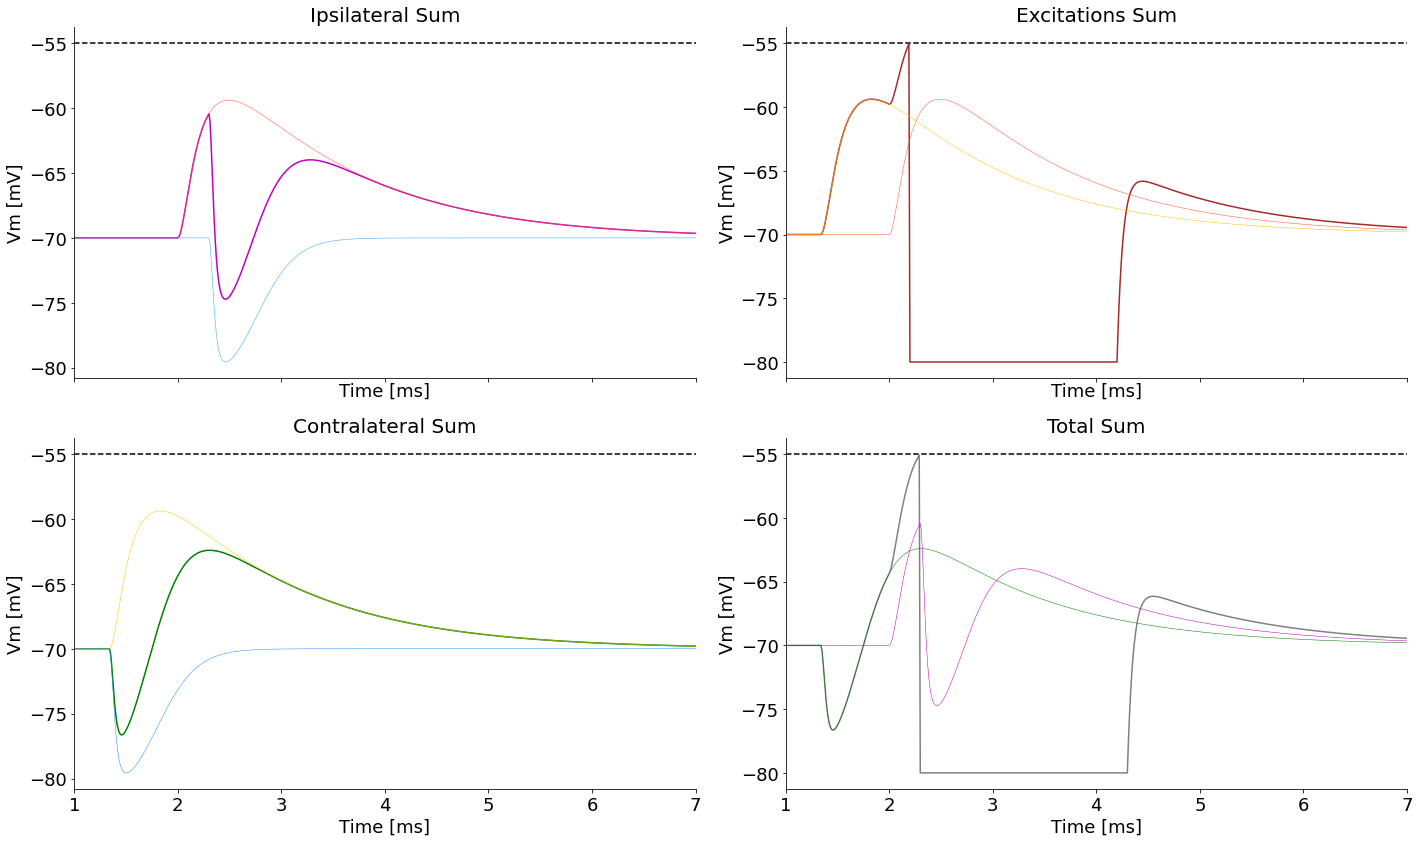

In [278]:
angle = -80
tone = 100
time_sim = 10
lim = 7

taus = np.zeros(4)
taus[:] = [0.2, 0.1, 1.2, 0.18] #default: [0.2, 2, 0.2, 2] #40: [0.2, 0.1, 0.5, 0.1] #15: [0.2, 0.1, 0.2, 0.01] # 85 [0.2, 0.1, 1.2, 0.18] #65: [0.2, 0.1, 0.75, 0.14]
taus = taus
w_ratio = 10

c_mso = 1
we = 3
wi = -we*w_ratio
delays_mso = [1,1.3,1, 1] #ms
weights_mso = [we,wi,we,wi]
v_th = -55

w_head = 22 #cm
v_sound = 33000 #cm/s
delta_x = (w_head*np.sin(np.deg2rad(angle)))
itd = round(1000*delta_x/v_sound,2) #ms
ipd = 2*np.pi*itd*tone/1000

nest.ResetKernel()
nest.local_num_threads = 16
nest.resolution = 0.01 

ipsi_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1, time_sim+1, 1000/tone),2)})

contra_e = nest.Create('spike_generator', 1, params={"spike_times": np.around(np.arange(1+itd, time_sim+itd+1, 1000/tone),2)})

mso = nest.Create('iaf_cond_beta', 8,
                  params = {'V_reset': -80, 'V_th': v_th})


for i in range(8):
    mso[i].set(C_m = c_mso, tau_rise_ex = taus[0], tau_rise_in = taus[1], tau_decay_ex = taus[2], tau_decay_in = taus[3])

s = nest.Create('spike_recorder')

m = nest.Create('multimeter', 1, {"record_from": ['V_m']})
nest.SetStatus(m, {'interval': 0.01})

nest.Connect(mso, s, 'all_to_all')
nest.Connect(ipsi_e, s, 'one_to_one')
nest.Connect(contra_e, s, 'one_to_one')

nest.Connect(m, mso, 'all_to_all')

nest.Connect(ipsi_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
nest.Connect(ipsi_e, mso[1], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[1]})
nest.Connect(contra_e, mso[2], 'one_to_one', syn_spec = {"weight":weights_mso[2], "delay": delays_mso[2]})
nest.Connect(contra_e, mso[3], 'one_to_one', syn_spec = {"weight":weights_mso[3], "delay": delays_mso[3]})

nest.Connect(ipsi_e, mso[4], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
nest.Connect(ipsi_e, mso[4], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[1]})

nest.Connect(contra_e, mso[5], 'one_to_one', syn_spec = {"weight":weights_mso[2], "delay": delays_mso[2]})
nest.Connect(contra_e, mso[5], 'one_to_one', syn_spec = {"weight":weights_mso[3], "delay": delays_mso[3]})

nest.Connect(ipsi_e, mso[6], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
nest.Connect(contra_e, mso[6], 'one_to_one', syn_spec = {"weight":weights_mso[2], "delay": delays_mso[2]})

nest.Connect(ipsi_e, mso[7], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
nest.Connect(ipsi_e, mso[7], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[1]})
nest.Connect(contra_e, mso[7], 'one_to_one', syn_spec = {"weight":weights_mso[2], "delay": delays_mso[2]})
nest.Connect(contra_e, mso[7], 'one_to_one', syn_spec = {"weight":weights_mso[3], "delay": delays_mso[3]})


nest.Simulate(time_sim)
#data = s.get('events')
pot = m.get('events')

text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title

col = ['#FF5733', '#33A1FD', '#FFC300', '#1E90FF', 'm', 'g', 'brown', 'grey']
fig, ax = plt.subplots(2,2, figsize=(20,12), sharex = True)

for j in range(2):
    for i in range(2):
        ax[i, j].set_xlim(1, lim)
        ax[i, j].axhline(y = -55, color = 'k', linestyle = '--')
        ax[i, j].plot(pot['times'][np.where(pot['senders'] == mso[2*j+i+4].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[2*j+i+4].get('global_id'))], color = col[2*j+i+4])
        ax[i, j].spines['top'].set_visible(False)
        ax[i, j].spines['right'].set_visible(False)
        ax[i, j].set_xlabel("Time [ms]")
        ax[i, j].set_ylabel("Vm [mV]")

ax[0, 0].set_title('Ipsilateral Sum')
ax[1, 0].set_title('Contralateral Sum')
ax[0, 1].set_title('Excitations Sum')
ax[1, 1].set_title('Total Sum')

ax[0, 0].plot(pot['times'][np.where(pot['senders'] == mso[0].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[0].get('global_id'))], color = col[0], linewidth = 0.5)
ax[0, 0].plot(pot['times'][np.where(pot['senders'] == mso[1].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[1].get('global_id'))], color = col[1], linewidth = 0.5)

ax[1, 0].plot(pot['times'][np.where(pot['senders'] == mso[2].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[2].get('global_id'))], color = col[2], linewidth = 0.5)
ax[1, 0].plot(pot['times'][np.where(pot['senders'] == mso[3].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[3].get('global_id'))], color = col[3], linewidth = 0.5)

ax[0, 1].plot(pot['times'][np.where(pot['senders'] == mso[0].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[0].get('global_id'))], color = col[0], linewidth = 0.5)
ax[0, 1].plot(pot['times'][np.where(pot['senders'] == mso[2].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[2].get('global_id'))], color = col[2], linewidth = 0.5)

ax[1, 1].plot(pot['times'][np.where(pot['senders'] == mso[4].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[4].get('global_id'))], color = col[4], linewidth = 0.5)
ax[1, 1].plot(pot['times'][np.where(pot['senders'] == mso[5].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[5].get('global_id'))], color = col[5], linewidth = 0.5)

fig.tight_layout()


In [279]:
pot

{'senders': array([ 3,  3,  3, ..., 10, 10, 10]),
 'times': array([0.01, 0.02, 0.03, ..., 8.98, 8.99, 9.  ]),
 'V_m': array([-70.        , -70.        , -70.        , ..., -69.89323486,
        -69.89411946, -69.89499674])}